## Estimate the amount of oil cargo carried by ATBs by comparing DOE cargo transfers to tank capacities

This notebook is a compliment to [ATB_FullEmptyRatio_AISplot.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/ATB_FullEmptyRatio_AISplot.ipynb) and [ATB_FullEmptyRatio.ipynb](https://github.com/MIDOSS/analysis-rachael/blob/main/notebooks/monte_carlo/ATB_FullEmptyRatio.ipynb). See also [Susan's spreadsheet](https://docs.google.com/spreadsheets/d/1nyp_gtYGsc4xvN7eLj48I6eWmitgb-Plut-vmX79UMM/edit#gid=0) on oil transfer 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
 ```
or, to activate this environment, use
```
 conda activate monte_carlo
 ```
To deactivate an active environment, use
```
 conda deactivate
 ```

In [1]:
import pandas 
import numpy 
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import datetime

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_DOE_df, get_DOE_atb

In [71]:
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'

# ATB input spreadsheet
atb_capacity_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/ATB_oil_capacity.xlsx'
)
# ATB output spreadsheet
atb_fullness_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/ATB_fullness.xlsx'
)

# yaml output directory
yaml_out_dir = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)

# Facility names and lat/lon information file
facilities_xlsx = Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
    'Oil_Transfer_Facilities.xlsx'
)

# Constants
bbl2gal = 42  #barrel to gallons

### Create histogram of percent fill for each transfer, by each vessel, for import and export transfers combined
- Create dictionary `capacity` with tank barge and oil capacity as key:value pairs
- Load DOE data and create dataframes for each tank barge
- Create dictionary of cargo fullness by ATB tank barge
    - Group dataframes by AntID
    - Estimate fullness per transfer based on cargo capacity information. NOTE: Assumption here is that ATBs fill at one location rather than, e.g., two separate locations
    - (save transfer dates and tank barge names in each bin? )
- Create a histogram of percent full for imports, exports and combined for each vessel
- Add up the combined histograms across all vessels

#### Create dictionary `capacity` with tank barge and oil capacity as key:value pairs

In [3]:
atb_df = pandas.read_excel(
    atb_capacity_xlsx,
    sheet_name='Cargo Capacities', 
    usecols="A,H"
    )
capacity = {}
for idx,name in enumerate(atb_df['DOE name']):
    capacity[name] = atb_df['95% or 96% Capacity (bbls)'][idx] * bbl2gal


In [4]:
capacity

{'ATB BARGE ZIDELL MARINE 277': 3379068.0,
 'ATB BARGE FIGHT FANCONI ANEMIA': 3517500.0,
 'ATB BARGE DR. ROBERT J. BEALL': 3517500.0,
 'ATB BARGE ONEDREAM': 3445218.0,
 'ATB BARGE EDWARD ITTA': 3436650.0,
 'ATB BARGE ALL ABOARD FOR A CURE': 3445470.0,
 'ATB BARGE 550-2': 6689928.0,
 'ATB BARGE 550-3': 6689928.0,
 'ATB BARGE DBL 78': nan,
 'ATB BARGE KIRBY 185-01': 7770000.0,
 'ATB BARGE 650-7': 7628880.0,
 'ATB BARGE 650-10': 7628880.0,
 'ATB BARGE DBL 185': 7770000.0,
 'ATB BARGE 650-2': 7628880.0,
 'ATB TUG ISLAND MONARCH': nan,
 'ITB SUPPLIER': nan,
 'ITB VANCOUVER': 1056688.08,
 'ITB ISLAND TRADER': 2881662.0}

#### Load DOE data 

In [5]:
# load data
[imports, exports]=get_DOE_atb(
    DOE_2018_xlsx, 
    facilities_xlsx, 
    transfer_type = 'cargo', 
    facilities='selected'
)
imports.Deliverer = imports.Deliverer.replace('ATB BARGE DBL185','ATB BARGE DBL 185')
exports.Receiver = exports.Receiver.replace('ATB BARGE DBL185','ATB BARGE DBL 185')

In [6]:
imports.head(1)

,AntID,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription,ImportRegion,ExportRegion
5,173491,2018-01-01 07:00:00,ITB ISLAND TRADER,SeaPort Sound Terminal,GASOLINE,966000.0,Cargo,TANK BARGE,Facility,Puget Sound,not attributed


#### Create an ordered list of ATB names sorted by highest to lowest number of transfers

In [7]:
# extract the important stuff
imports_sm = imports[['AntID','Deliverer','TransferQtyInGallon']]
exports_sm = exports[['AntID','Receiver','TransferQtyInGallon']]
# define way to group dataframe
aggregate_in = {
    'AntID': 'first',
    'Deliverer': 'first',
    'TransferQtyInGallon': 'sum'
}
aggregate_out = {
    'AntID': 'first', 
    'Receiver': 'first',
    'TransferQtyInGallon': 'sum'
}

In [8]:
count_in = {}
count_out = {}
count = {}
# count exports
exports_sm_AndID = exports_sm.groupby(exports['AntID']).aggregate(aggregate_out)
count_out =  exports_sm_AndID[['Receiver','TransferQtyInGallon']].groupby(
    'Receiver').count().rename(columns={'TransferQtyInGallon':'Count'})
count_out.index.name = 'Name'
count_out.reset_index(inplace=True)
# count imports
imports_sm_AndID = imports_sm.groupby(imports['AntID']).aggregate(aggregate_in)
count_in =  imports_sm_AndID[['Deliverer','TransferQtyInGallon']].groupby(
    'Deliverer').count().rename(columns={'TransferQtyInGallon':'Count'})
count_in.index.name = 'Name'
count_in.reset_index(inplace=True)
#create new df 
count = pandas.DataFrame(
    {'Name':list(count_out['Name']) + list(set(count_in['Name']) - set(count_out['Name']))})
count = pandas.merge(
    left = count,
    right = count_out,
    how = 'left',
    on = 'Name'
).fillna(0)
# Add import transfers to export transfers
count = count.set_index('Name').add(count_in.set_index('Name'), fill_value=0).reset_index()
# order list by total number of transfers
count = count.sort_values(by='Count', ascending=False)
count

,Name,Count
6,ATB BARGE DBL 185,73.0
5,ATB BARGE ALL ABOARD FOR A CURE,70.0
0,ATB BARGE 550-2,62.0
12,ATB BARGE ONEDREAM,61.0
2,ATB BARGE 650-10,46.0
10,ATB BARGE FIGHT FANCONI ANEMIA,44.0
13,ATB BARGE ZIDELL MARINE 277,30.0
15,ITB ISLAND TRADER,27.0
11,ATB BARGE KIRBY 185-01,16.0
1,ATB BARGE 550-3,10.0


#### Create dictionary of cargo fullness by tank barge 

In [9]:
# extract the important stuff
imports = imports[
    ['AntID','StartDateTime','Deliverer','Receiver',
     'Product','TransferQtyInGallon']
]
exports = exports[
    ['AntID','StartDateTime','Deliverer','Receiver',
     'Product','TransferQtyInGallon']
]
# define way to group dataframe
aggregation_functions = {
    'AntID': 'first', 
    'StartDateTime': 'first',
    'Deliverer': 'first', 
    'Receiver': 'first',
    'Product': lambda x: x.tolist(),
    'TransferQtyInGallon': 'sum'
}

In [10]:
imports_fill = {}
exports_fill = {}
fullness = {}

# first group by transfer ID (AntID) and add `TransferQtyInGallon` for each AntID
imports_byAntID = imports.groupby(imports['AntID']).aggregate(aggregation_functions)
exports_byAntID = exports.groupby(exports['AntID']).aggregate(aggregation_functions)

# loop through ordered list of vessel names and create excel sheet with %fullness 
# values for each AntID, by vessel
with pandas.ExcelWriter(atb_fullness_xlsx) as writer:
    for idx,name in enumerate(count['Name']):
        # ~~~ imports ~~~
        imports_fill[name] = imports_byAntID.loc[
            imports_byAntID['Deliverer']==name,
            ['StartDateTime','TransferQtyInGallon','Receiver','Product']
        ].rename(columns={'Receiver':'Facility'})
        # divide total gallons transferred by cargo capacity to get fullness 
        imports_fill[name]['FillFraction'] = numpy.zeros(
            len(imports_fill[name]['TransferQtyInGallon']))  
        imports_fill[name]['FillFraction'] = numpy.asarray(
            [x / capacity[name] 
             for x in imports_fill[name]['TransferQtyInGallon']]
        )
        imports_fill[name]['direction'] = 'import'
        # ~~~ exports ~~~
        exports_fill[name] = exports_byAntID.loc[
            exports_byAntID['Receiver']==name,
            ['StartDateTime','TransferQtyInGallon','Deliverer','Product']
        ].rename(columns={'Deliverer':'Facility'})  
        # divide total gallons transferred by cargo capacity to get fullness 
        exports_fill[name]['FillFraction'] = numpy.zeros(
            len(exports_fill[name]['TransferQtyInGallon']))
        exports_fill[name]['FillFraction'] = numpy.asarray([
            x / capacity[name] 
            for x in exports_fill[name]['TransferQtyInGallon']
        ])
        exports_fill[name]['direction'] = 'export'

        # ~~~ combine imports and exports ~~~
        frames = [imports_fill[name], exports_fill[name]]
        fullness[name] = pandas.concat(frames).reset_index()

        # ~~~ save to excel with new tab for each ATB ~~~ 
        fullness[name].to_excel(writer, sheet_name=name)

### Create a histogram of percent full for imports, exports and combined for each vessel

In [11]:
count['Name'][0]

'ATB BARGE 550-2'

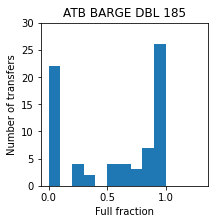

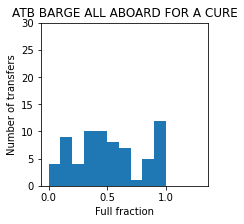

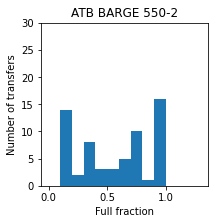

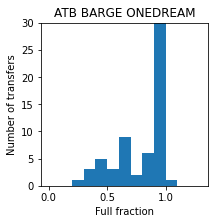

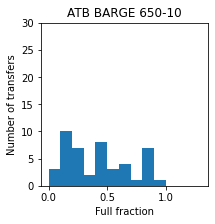

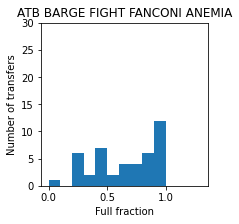

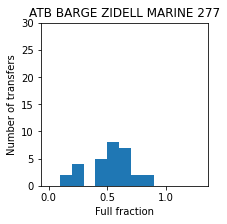

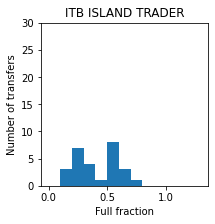

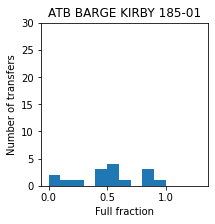

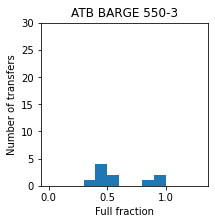

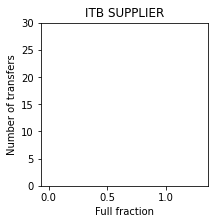

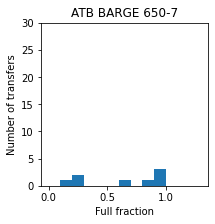

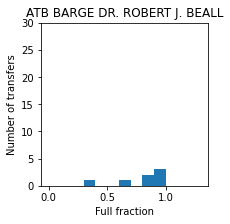

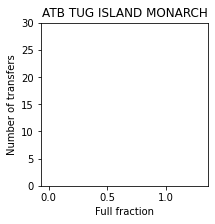

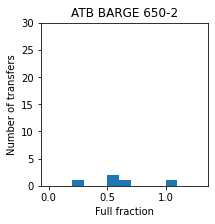

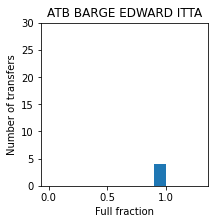

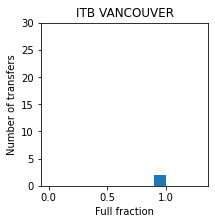

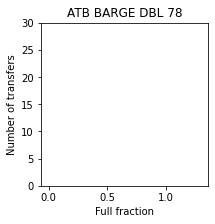

In [45]:
nbins = 14
max_full = 1.4
bin_values = numpy.arange(0,max_full,max_full/nbins)
binned_transfers = numpy.zeros(nbins-1)
# select barge for testing
#name = count['Name'][0]
# n={}
# bins={}
# patches={}
for idx,name in enumerate(count['Name']):
    # the histogram of the data
    fig, ax = plt.subplots(figsize = (3,3))
    n, bins, patches = ax.hist(
        fullness[name]['FillFraction'],
        bins = bin_values)
    ax.set_xlabel('Full fraction')
    ax.set_ylabel('Number of transfers')
    ax.set_ylim(0,30)
    ax.set_title(f'{name}')
    
    # combine all transfers into one
    binned_transfers = numpy.add(binned_transfers,n)

### Add up and plot combined histograms across all vessels
- add all transfers with fill values > 1.0 to 1.0.  

In [46]:
len(bins)

14

In [47]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3])

In [48]:
binned_transfers

array([ 32.,  40.,  39.,  33.,  46.,  47.,  47.,  24.,  41., 113.,   2.,
         0.,   0.])

In [49]:
binned_transfers[9] += binned_transfers[-3:].sum()
binned_transfers = numpy.delete(binned_transfers,[10,11,12])
binned_transfers

array([ 32.,  40.,  39.,  33.,  46.,  47.,  47.,  24.,  41., 115.])

In [50]:
len(binned_transfers)

10

In [55]:
# set bins to upper bound of range for fill capacity
bins = numpy.arange(.1,1.1,.1)

In [57]:
len(bins)

10

Text(0.5, 0, 'Fullness fraction')

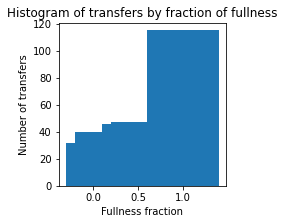

In [58]:
#centered_bins=[(bins[i] + bins[i+1])/2 for i in numpy.arange(0,nbins-1)]
fig, ax = plt.subplots(figsize = (3,3))
ax.bar(bins, binned_transfers)
ax.set_title('Histogram of transfers by fraction of fullness')
ax.set_ylabel('Number of transfers')
ax.set_xlabel('Fullness fraction')

In [59]:
binned_transfers

array([ 32.,  40.,  39.,  33.,  46.,  47.,  47.,  24.,  41., 115.])

In [60]:
binned_transfers.sum()

464.0

In [64]:
fullness_weight = numpy.array([transfers/binned_transfers.sum() for transfers in binned_transfers])

In [65]:
fullness_weight

array([0.06896552, 0.0862069 , 0.08405172, 0.07112069, 0.09913793,
       0.1012931 , 0.1012931 , 0.05172414, 0.08836207, 0.24784483])

In [66]:
fullness_weight.sum()

1.0

### Output to .yaml

In [73]:
fullness = {}
fullness['weights'] = fullness_weight.tolist()
fullness['fill_fraction'] = bins.tolist()

In [74]:
fullness['fill_fraction']

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [76]:
with open(yaml_out_dir/'fill_fraction.yaml', 'w') as file:
    documents = yaml.safe_dump(fullness, file)